In [ ]:
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Reshape
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.utils import plot_model
from keras.models import load_model
import matplotlib.pyplot as plt
from numpy.random import rand
from numpy import zeros
from numpy.random import randn
from keras.datasets.cifar10 import load_data
from numpy.random import randint
from numpy import ones

In [ ]:
def make_D(in_shape = (32,32,3)):

    model = Sequential([

        Conv2D(64, (3,3), padding = 'same', input_shape = in_shape),
        LeakyReLU(alpha = 0.2),

        Conv2D(128, (3,3), strides = (2,2), padding = 'same'),
        LeakyReLU(alpha = 0.2),

        Conv2D(128, (3,3), strides = (2,2), padding = 'same'),
        LeakyReLU(alpha = 0.2),

        Conv2D(256, (3,3), strides = (2,2), padding = 'same'),
        LeakyReLU(alpha = 0.2),

        Flatten(),
        Dropout(0.4),
        Dense(1, activation = 'sigmoid')
    ])

    opt = Adam(learning_rate = 0.0002, beta_1 = 0.5)
    model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

    return model

In [ ]:
def make_G(latent_dims):

    nodes = 256*4*4
    model = Sequential([

        Dense(nodes, input_dim = latent_dims),
        LeakyReLU(alpha = 0.2),
        Reshape((4, 4, 256)),

        Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same'),
        LeakyReLU(alpha = 0.2),

        Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same'),
        LeakyReLU(alpha = 0.2),

        Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same'),
        LeakyReLU(alpha = 0.2),

        Conv2D(3, (3,3), activation = 'tanh', padding = 'same')
    ])

    return model

In [ ]:
def make_GAN(G, D):

    D.trainable = False

    GAN = Sequential()

    GAN.add(G)
    GAN.add(D)

    opt = Adam(learning_rate = 0.0002, beta_1 = 0.5)

    GAN.compile(loss = 'binary_crossentropy', optimizer = opt)

    return GAN

In [ ]:
def load_real_samples():
    (Xt, _), (_, _) = load_data()

    X = Xt.astype('float32')

    X = (X - 127.5) / 127.5

    return X

In [ ]:
def generate_real_samples(dataset, n_samples):

    i = randint(0, dataset.shape[0], n_samples)

    X = dataset[i]

    y = ones((n_samples, 1))
    return X, y

In [ ]:
def generate_latent_points(n_samples, latent_dims):
    x = randn(n_samples * latent_dims)
    x = x.reshape(n_samples, latent_dims)

    return x

In [ ]:
def generate_fake_samples(G, n_samples, latent_dim):

    l = generate_latent_points(n_samples, latent_dim)
    X = G.predict(l, verbose = 0)
    y = zeros((n_samples, 1))

    return X, y

In [ ]:
def save_plot(samples, epoch, n = 5):

    samples = (samples + 1) / 2.0

    for i in range(n * n):

        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(samples[i])

    filename = f'gen_plot_{epoch+1}.png'
    plt.savefig(filename)
    plt.close()

In [ ]:
def view_performance(epoch, dataset, G, D, latent_dim, n_samples = 150):

    X_real, y_real = generate_real_samples(dataset, n_samples)

    _, acc_real = D.evaluate(X_real, y_real, verbose = 0)

    X_fake, y_fake = generate_fake_samples(G, n_samples, latent_dim)

    _, acc_fake = D.evaluate(X_fake, y_fake, verbose = 0)

    print(f'-> Acc real : {acc_real:.2f} - Acc_fake : {acc_fake:.2f}')

    save_plot(X_fake, epoch)

    filename = f'gen_model{epoch+1}.h5'
    G.save(filename)

In [ ]:
def train_GAN(G, D, GAN, dataset, latent_dim, epochs = 20, batch_size = 128):
    batch_p_epoch = int(dataset.shape[0] / batch_size)
    half_batch = int(batch_size / 2)

    for epoch in range(epochs):
        for batch in range(batch_p_epoch):

            x_real, y_real = generate_real_samples(dataset, half_batch)

            D_lossR, _ = D.train_on_batch(x_real, y_real)

            x_fake, y_fake = generate_fake_samples(G, half_batch, latent_dim)

            D_lossF, _ = D.train_on_batch(x_fake, y_fake)

            x_gan = generate_latent_points(batch_size, latent_dim)

            y_gan = ones((batch_size, 1))

            G_loss = GAN.train_on_batch(x_gan, y_gan)

            print(f'{epoch+1}/{epochs} - {batch+1}/{batch_p_epoch} - D_lossR : {D_lossR:.2f} - D_lossF : {D_lossF:.2f} - G_loss : {G_loss:.2f}')

        # check accuracy after every for every 10 epochs
        if (epoch+1) % 10 == 0 :
            view_performance(epoch, dataset, G, D, latent_dim)

In [ ]:
L_dim = 100

Dis = make_D()

Gen = make_G(L_dim)

gan = make_GAN(Gen, Dis)

cifar = load_real_samples()

170498071/170498071 [==============================] - 2s 0us/step


In [ ]:
train_GAN(Gen, Dis, gan, cifar, L_dim)

In [ ]:
'''
I made separate cells to save the models and images after a training session of 20 epochs
you may do the same if colab timeout gives you trouble.

removed them for clarity
'''

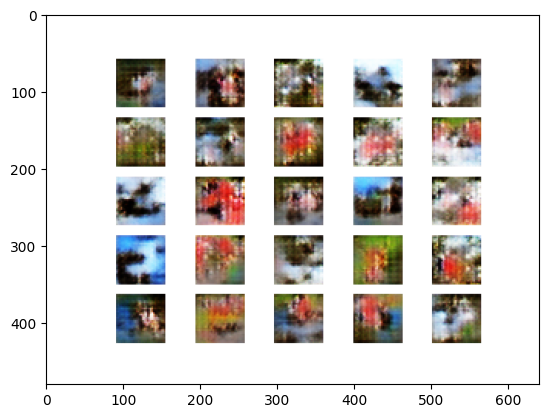

In [ ]:
# after 10 epochs
import matplotlib.image as mpimg
plt.imshow(mpimg.imread('gen_plot_10.png'))

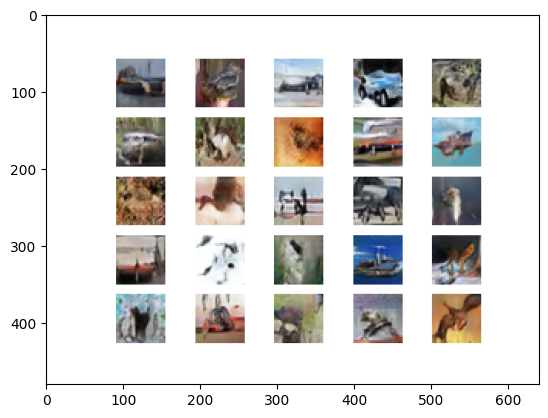

In [ ]:
# after 40 epochs, ignore the file naming :)

import matplotlib.image as mpimg
plt.imshow(mpimg.imread('gen_plot_20(2).png'))

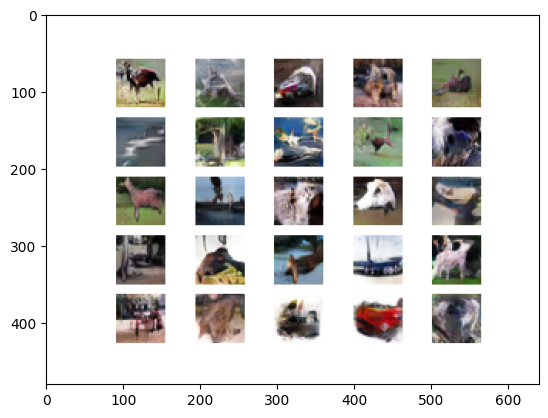

In [ ]:
# after 80 epochs

import matplotlib.image as mpimg
plt.imshow(mpimg.imread('gen_plot_20(4).png'))

In [ ]:
'''
too much training does not really make the output better.
the output after 50 epochs is pretty much what it looks like after another 150 epochs

and for a simple model as this, its actually good

i'll be updating the model
'''